# SVM IY010_simulation_7 Analysis: Varying 1 stat, fixing 2 stats

Visualise results when we vary 1 stat target at a time


In [11]:
from __future__ import annotations
import numpy as np
import pandas as pd
import glob
from pathlib import Path
from typing import Dict, Optional
import sys
import os
import re
from collections import defaultdict
import torch
import time
import matplotlib.pyplot as plt

# Add src directory to Python path
sys.path.append(str(Path.cwd().parent.parent.parent / "src"))

# Import custom modules
from classifiers.svm_classifier import svm_classifier, grid_search_svm
from models.TF_transformer import TFTransformer, ModelCfg
from utils.data_processing import add_binary_labels, add_nearest_neighbour_labels
from utils.standardise_time_series import standardise_time_series
from utils.shuffle_time_series import shuffle_time_series

# Import sklearn modules for SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Initialize results storage
results_dict = {
    'parameter': [],
    'original_accuracy': [],
    'shuffled_accuracy': []
}

Changing ``t_ac_target``:

In [7]:
##### Set up directory paths for data loading ######
BASE_DIR = Path.cwd().parent
OUT_DIR = BASE_DIR
SYNTHETIC_DIR = BASE_DIR / "data_7_mu_cv_fixed" 
RESULTS_CSV = "IY010_simulation_parameters_7_mu_cv_fixed.csv"
results_csv_path = BASE_DIR / RESULTS_CSV
results = pd.read_csv(results_csv_path)
results = results[results["success"]].dropna(
    subset=["mu_observed", "cv_observed", "t_ac_observed"]
)

label_column = 't_ac_target' 
labelled_results = add_binary_labels(results, label_column)
# labelled_results = add_nearest_neighbour_labels(results, positive_on=label_column)
##### Set up directory paths for data loading ######

##### Use standardise_time_series utility function ######
# Collect all DataFrames and their labels
data_frames = []
labels = []

for i in range(len(results)):
    trajectory_filename = results["trajectory_filename"].values[i]
    DATA_CSV = SYNTHETIC_DIR / trajectory_filename
    data = pd.read_csv(DATA_CSV)
    data_frames.append(data)
    
    # Get the corresponding label from the results csv
    label_value = labelled_results[labelled_results['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
    labels.append(label_value)

# Use the utility function to standardize
labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")

print(f"📏 Standardized dataset:")
print(f"   NaN values: {labelled_data.isnull().sum().sum()}")
##### Use standardise_time_series utility function ######

# =========================================================
# Prepare Features and Labels for SVM
# =========================================================
df = labelled_data.copy()
# Extract labels
y = df["label"].values

# Extract features (all columns except 'label')
X = df.drop(columns=["label"]).values

print(f"Data preparation for SVM:")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Labels shape: {y.shape}")
print(f"  Number of classes: {len(np.unique(y))}")
print(f"  Class distribution: {np.bincount(y)}")
print(f"  Memory usage: {X.nbytes / 1024**2:.2f} MB")

# Check for any NaN or infinite values
if np.any(np.isnan(X)):
    print("⚠️  Warning: NaN values detected in features")
if np.any(np.isinf(X)):
    print("⚠️  Warning: Infinite values detected in features")
    
print("✅ Data ready for SVM classification!")

# SVM Parameters (using defaults from svm_classifier function)
SVM_C = 1.0           # Regularization parameter
SVM_GAMMA = 'scale'   # Kernel coefficient 
SVM_KERNEL = 'rbf'    # Kernel type

# Train/test split ratio
TEST_SPLIT = 0.2
RANDOM_STATE = 42

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SPLIT, 
    random_state=RANDOM_STATE,
    stratify=y  # Ensure balanced split across classes
)

# Record training time
start_time = time.time()

# Train SVM using the imported svm_classifier function
svm_accuracy = svm_classifier(
    X_train, X_test, y_train, y_test,
    svm_C=SVM_C,
    svm_gamma=SVM_GAMMA, 
    svm_kernel=SVM_KERNEL,
    print_classification_report=True,
    print_confusion_matrix=True,
)

training_time = time.time() - start_time
print(f"⏱️  SVM ({SVM_KERNEL}) training and evaluation time: {training_time:.2f} seconds")

# =========================================================
# Experiment: Does Temporal Order Matter for Classification?
# =========================================================
print("\n🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact")
# Use the utility function to create shuffled data
df_shuffled = shuffle_time_series(
    df, 
    preserve_columns=['label'], 
    random_state=RANDOM_STATE
)

# Extract features and labels from shuffled data
y_shuffled = df_shuffled["label"].values
X_shuffled = df_shuffled.drop(columns=["label"]).values

# Split the shuffled data
X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(
    X_shuffled, 
    y_shuffled, 
    test_size=TEST_SPLIT,
    random_state=RANDOM_STATE,
    stratify=y_shuffled
)

# Record training time
start_time = time.time()

# Train SVM on shuffled data
svm_accuracy_shuffled = svm_classifier(
    X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled,
    svm_C=SVM_C,
    svm_gamma=SVM_GAMMA, 
    svm_kernel=SVM_KERNEL,
    print_classification_report=True,
    print_confusion_matrix=True,
)
training_time = time.time() - start_time
print(f"⏱️  SVM ({SVM_KERNEL}) training and evaluation time: {training_time:.2f} seconds")

# Store results
results_dict['parameter'].append('t_ac_target')
results_dict['original_accuracy'].append(svm_accuracy)
results_dict['shuffled_accuracy'].append(svm_accuracy_shuffled)

📏 Standardized dataset:
   NaN values: 0
Data preparation for SVM:
  Feature matrix shape: (9400, 174)
  Labels shape: (9400,)
  Number of classes: 2
  Class distribution: [4600 4800]
  Memory usage: 12.48 MB
✅ Data ready for SVM classification!
=== SVM (RBF Kernel) Classification Accuracy: 0.83 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       920
           1       0.78      0.94      0.85       960

    accuracy                           0.83      1880
   macro avg       0.85      0.83      0.83      1880
weighted avg       0.85      0.83      0.83      1880


Confusion Matrix:
[[665 255]
 [ 58 902]]
⏱️  SVM (rbf) training and evaluation time: 4.32 seconds

🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact
=== SVM (RBF Kernel) Classification Accuracy: 0.83 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81

Changing ``cv_target``:

In [8]:
##### Set up directory paths for data loading ######
BASE_DIR = Path.cwd().parent
OUT_DIR = BASE_DIR
SYNTHETIC_DIR = BASE_DIR / "data_7_mu_t_ac_fixed" 
RESULTS_CSV = "IY010_simulation_parameters_7_mu_t_ac_fixed.csv"
results_csv_path = BASE_DIR / RESULTS_CSV
results = pd.read_csv(results_csv_path)
results = results[results["success"]].dropna(
    subset=["mu_observed", "cv_observed", "t_ac_observed"]
)

label_column = "cv_target" 
labelled_results = add_binary_labels(results, label_column)
# labelled_results = add_nearest_neighbour_labels(results, positive_on=label_column)
##### Set up directory paths for data loading ######

##### Use standardise_time_series utility function ######
# Collect all DataFrames and their labels
data_frames = []
labels = []

for i in range(len(results)):
    trajectory_filename = results["trajectory_filename"].values[i]
    DATA_CSV = SYNTHETIC_DIR / trajectory_filename
    data = pd.read_csv(DATA_CSV)
    data_frames.append(data)
    
    # Get the corresponding label from the results csv
    label_value = labelled_results[labelled_results['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
    labels.append(label_value)

# Use the utility function to standardize
labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")

print(f"📏 Standardized dataset:")
print(f"   NaN values: {labelled_data.isnull().sum().sum()}")
##### Use standardise_time_series utility function ######

# =========================================================
# Prepare Features and Labels for SVM
# =========================================================
df = labelled_data.copy()
# Extract labels
y = df["label"].values

# Extract features (all columns except 'label')
X = df.drop(columns=["label"]).values

print(f"Data preparation for SVM:")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Labels shape: {y.shape}")
print(f"  Number of classes: {len(np.unique(y))}")
print(f"  Class distribution: {np.bincount(y)}")
print(f"  Memory usage: {X.nbytes / 1024**2:.2f} MB")

# Check for any NaN or infinite values
if np.any(np.isnan(X)):
    print("⚠️  Warning: NaN values detected in features")
if np.any(np.isinf(X)):
    print("⚠️  Warning: Infinite values detected in features")
    
print("✅ Data ready for SVM classification!")

# SVM Parameters (using defaults from svm_classifier function)
SVM_C = 1.0           # Regularization parameter
SVM_GAMMA = 'scale'   # Kernel coefficient 
SVM_KERNEL = 'rbf'    # Kernel type

# Train/test split ratio
TEST_SPLIT = 0.2
RANDOM_STATE = 42

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SPLIT, 
    random_state=RANDOM_STATE,
    stratify=y  # Ensure balanced split across classes
)

# Record training time
start_time = time.time()

# Train SVM using the imported svm_classifier function
svm_accuracy = svm_classifier(
    X_train, X_test, y_train, y_test,
    svm_C=SVM_C,
    svm_gamma=SVM_GAMMA, 
    svm_kernel=SVM_KERNEL,
    print_classification_report=True,
    print_confusion_matrix=True,
)

training_time = time.time() - start_time
print(f"⏱️  SVM ({SVM_KERNEL}) training and evaluation time: {training_time:.2f} seconds")

# =========================================================
# Experiment: Does Temporal Order Matter for Classification?
# =========================================================
print("\n🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact")
# Use the utility function to create shuffled data
df_shuffled = shuffle_time_series(
    df, 
    preserve_columns=['label'], 
    random_state=RANDOM_STATE
)

# Extract features and labels from shuffled data
y_shuffled = df_shuffled["label"].values
X_shuffled = df_shuffled.drop(columns=["label"]).values

# Split the shuffled data
X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(
    X_shuffled, 
    y_shuffled, 
    test_size=TEST_SPLIT,
    random_state=RANDOM_STATE,
    stratify=y_shuffled
)

# Record training time
start_time = time.time()

# Train SVM on shuffled data
svm_accuracy_shuffled = svm_classifier(
    X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled,
    svm_C=SVM_C,
    svm_gamma=SVM_GAMMA, 
    svm_kernel=SVM_KERNEL,
    print_classification_report=True,
    print_confusion_matrix=True,
)
training_time = time.time() - start_time
print(f"⏱️  SVM ({SVM_KERNEL}) training and evaluation time: {training_time:.2f} seconds")

# Store results
results_dict['parameter'].append('cv_target')
results_dict['original_accuracy'].append(svm_accuracy)
results_dict['shuffled_accuracy'].append(svm_accuracy_shuffled)

📏 Standardized dataset:
   NaN values: 0
Data preparation for SVM:
  Feature matrix shape: (9600, 194)
  Labels shape: (9600,)
  Number of classes: 2
  Class distribution: [4800 4800]
  Memory usage: 14.21 MB
✅ Data ready for SVM classification!
=== SVM (RBF Kernel) Classification Accuracy: 0.92 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       960
           1       0.91      0.93      0.92       960

    accuracy                           0.92      1920
   macro avg       0.92      0.92      0.92      1920
weighted avg       0.92      0.92      0.92      1920


Confusion Matrix:
[[877  83]
 [ 72 888]]
⏱️  SVM (rbf) training and evaluation time: 1.77 seconds

🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact
=== SVM (RBF Kernel) Classification Accuracy: 0.92 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92

Changing ``mu_target``:

In [9]:
##### Set up directory paths for data loading ######
BASE_DIR = Path.cwd().parent
OUT_DIR = BASE_DIR
SYNTHETIC_DIR = BASE_DIR / "data_7_cv_t_ac_fixed" 
RESULTS_CSV = "IY010_simulation_parameters_7_cv_t_ac_fixed.csv"
results_csv_path = BASE_DIR / RESULTS_CSV
results = pd.read_csv(results_csv_path)
results = results[results["success"]].dropna(
    subset=["mu_observed", "cv_observed", "t_ac_observed"]
)

label_column = "mu_target" 
labelled_results = add_binary_labels(results, label_column)
# labelled_results = add_nearest_neighbour_labels(results, positive_on=label_column)
##### Set up directory paths for data loading ######

##### Use standardise_time_series utility function ######
# Collect all DataFrames and their labels
data_frames = []
labels = []

for i in range(len(results)):
    trajectory_filename = results["trajectory_filename"].values[i]
    DATA_CSV = SYNTHETIC_DIR / trajectory_filename
    data = pd.read_csv(DATA_CSV)
    data_frames.append(data)
    
    # Get the corresponding label from the results csv
    label_value = labelled_results[labelled_results['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
    labels.append(label_value)

# Use the utility function to standardize
labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")

print(f"📏 Standardized dataset:")
print(f"   NaN values: {labelled_data.isnull().sum().sum()}")
##### Use standardise_time_series utility function ######

# =========================================================
# Prepare Features and Labels for SVM
# =========================================================
df = labelled_data.copy()
# Extract labels
y = df["label"].values

# Extract features (all columns except 'label')
X = df.drop(columns=["label"]).values

print(f"Data preparation for SVM:")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Labels shape: {y.shape}")
print(f"  Number of classes: {len(np.unique(y))}")
print(f"  Class distribution: {np.bincount(y)}")
print(f"  Memory usage: {X.nbytes / 1024**2:.2f} MB")

# Check for any NaN or infinite values
if np.any(np.isnan(X)):
    print("⚠️  Warning: NaN values detected in features")
if np.any(np.isinf(X)):
    print("⚠️  Warning: Infinite values detected in features")
    
print("✅ Data ready for SVM classification!")

# SVM Parameters (using defaults from svm_classifier function)
SVM_C = 1.0           # Regularization parameter
SVM_GAMMA = 'scale'   # Kernel coefficient 
SVM_KERNEL = 'rbf'    # Kernel type

# Train/test split ratio
TEST_SPLIT = 0.2
RANDOM_STATE = 42

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SPLIT, 
    random_state=RANDOM_STATE,
    stratify=y  # Ensure balanced split across classes
)

# Record training time
start_time = time.time()

# Train SVM using the imported svm_classifier function
svm_accuracy = svm_classifier(
    X_train, X_test, y_train, y_test,
    svm_C=SVM_C,
    svm_gamma=SVM_GAMMA, 
    svm_kernel=SVM_KERNEL,
    print_classification_report=True,
    print_confusion_matrix=True,
)

training_time = time.time() - start_time
print(f"⏱️  SVM ({SVM_KERNEL}) training and evaluation time: {training_time:.2f} seconds")

# =========================================================
# Experiment: Does Temporal Order Matter for Classification?
# =========================================================
print("\n🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact")
# Use the utility function to create shuffled data
df_shuffled = shuffle_time_series(
    df, 
    preserve_columns=['label'], 
    random_state=RANDOM_STATE
)

# Extract features and labels from shuffled data
y_shuffled = df_shuffled["label"].values
X_shuffled = df_shuffled.drop(columns=["label"]).values

# Split the shuffled data
X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(
    X_shuffled, 
    y_shuffled, 
    test_size=TEST_SPLIT,
    random_state=RANDOM_STATE,
    stratify=y_shuffled
)

# Record training time
start_time = time.time()

# Train SVM on shuffled data
svm_accuracy_shuffled = svm_classifier(
    X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled,
    svm_C=SVM_C,
    svm_gamma=SVM_GAMMA, 
    svm_kernel=SVM_KERNEL,
    print_classification_report=True,
    print_confusion_matrix=True,
)
training_time = time.time() - start_time
print(f"⏱️  SVM ({SVM_KERNEL}) training and evaluation time: {training_time:.2f} seconds")

# Store results
results_dict['parameter'].append('mu_target')
results_dict['original_accuracy'].append(svm_accuracy)
results_dict['shuffled_accuracy'].append(svm_accuracy_shuffled)

📏 Standardized dataset:
   NaN values: 0
Data preparation for SVM:
  Feature matrix shape: (4000, 194)
  Labels shape: (4000,)
  Number of classes: 2
  Class distribution: [2000 2000]
  Memory usage: 5.92 MB
✅ Data ready for SVM classification!
=== SVM (RBF Kernel) Classification Accuracy: 0.88 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       400
           1       0.91      0.86      0.88       400

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800


Confusion Matrix:
[[364  36]
 [ 57 343]]
⏱️  SVM (rbf) training and evaluation time: 0.36 seconds

🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact
=== SVM (RBF Kernel) Classification Accuracy: 0.88 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89 

Presenting the issue with the current method: when we shuffle the time series, retrain and retest SVM, the test accuracy take a toll, and this takes a much bigger toll if the classifier is learning on the autocorrelation time (temporal patterns) of the time series, as the time series loses the original temporal pattern. 


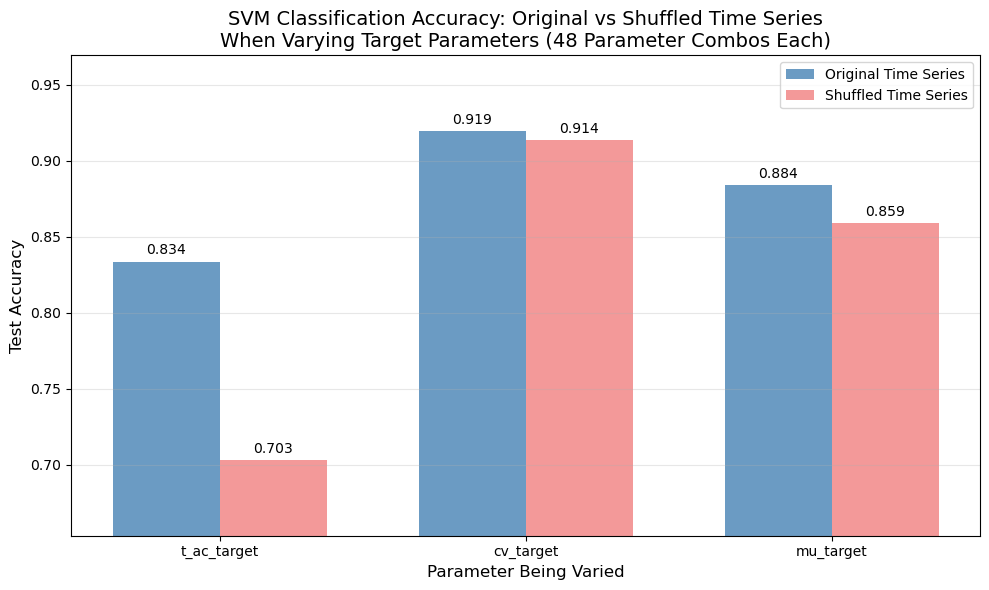


📊 SVM Accuracy Summary:
t_ac_target  | Original: 0.834 | Shuffled: 0.703 | Difference: +0.130
cv_target    | Original: 0.919 | Shuffled: 0.914 | Difference: +0.006
mu_target    | Original: 0.884 | Shuffled: 0.859 | Difference: +0.025

Average difference (Original - Shuffled): 0.054


In [70]:
# =========================================================
# Plot Results: SVM Accuracy Comparison Across Parameters
# =========================================================

# Create DataFrame from results
results_df = pd.DataFrame(results_dict)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define x-axis positions
x_positions = np.arange(len(results_df['parameter']))
width = 0.35  # Width of bars

# Create bars
bars1 = ax.bar(x_positions - width/2, results_df['original_accuracy'], 
               width, label='Original Time Series', alpha=0.8, color='steelblue')
bars2 = ax.bar(x_positions + width/2, results_df['shuffled_accuracy'], 
               width, label='Shuffled Time Series', alpha=0.8, color='lightcoral')

# Customize the plot
ax.set_xlabel('Parameter Being Varied', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('SVM Classification Accuracy: Original vs Shuffled Time Series\nWhen Varying Target Parameters (48 Parameter Combos Each)', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels(results_df['parameter'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=10)

add_value_labels(bars1)
add_value_labels(bars2)

# Set y-axis limits to better show differences
y_min = min(min(results_df['original_accuracy']), min(results_df['shuffled_accuracy'])) - 0.05
y_max = max(max(results_df['original_accuracy']), max(results_df['shuffled_accuracy'])) + 0.05
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 SVM Accuracy Summary:")
print("="*50)
for i, row in results_df.iterrows():
    param = row['parameter']
    orig_acc = row['original_accuracy']
    shuf_acc = row['shuffled_accuracy']
    diff = orig_acc - shuf_acc
    print(f"{param:12} | Original: {orig_acc:.3f} | Shuffled: {shuf_acc:.3f} | Difference: {diff:+.3f}")

print(f"\nAverage difference (Original - Shuffled): {np.mean(results_df['original_accuracy'] - results_df['shuffled_accuracy']):.3f}")

Plot time series showing a set of data with **extremely high t_ac value** and **extremely low t_ac value**, to illustrate how simple the classification problem is. Both in the original and shuffled form.

In [56]:
# =========================================================
# Plot Original vs Shuffled Time Series for t_ac_target Dataset
# =========================================================

# First, reload the t_ac_target dataset to get the original time series
BASE_DIR = Path.cwd().parent
SYNTHETIC_DIR = BASE_DIR / "data_7_mu_cv_fixed" 
RESULTS_CSV = "IY010_simulation_parameters_7_mu_cv_fixed.csv"
results_csv_path = BASE_DIR / RESULTS_CSV
results = pd.read_csv(results_csv_path)
results = results[results["success"]].dropna(
    subset=["mu_observed", "cv_observed", "t_ac_observed"]
)

# load the dataset where t_ac_observed is the highest and where t_observed is lowest
highest_t_ac_df = results.loc[results['t_ac_observed'].idxmax()]
lowest_t_ac_df = results.loc[results['t_ac_observed'].idxmin()]
# combine them horizontally
highest_lowest_results = pd.DataFrame([highest_t_ac_df, lowest_t_ac_df])
highest_lowest_results.index = ['highest_t_ac', 'lowest_t_ac']
highest_lowest_results

,mu_target,t_ac_target,cv_target,sigma_sum,success,error_message,rho,d,sigma_b,sigma_u,mu_observed,cv_observed,t_ac_observed,variance_observed,mean_rel_error_pct,cv_rel_error_pct,t_ac_rel_error_pct,trajectory_filename
highest_t_ac,1000,98.754398,1.0,1,True,NaN,1019.450076,0.010230,0.010035,0.989965,967.496516,1.012965,97.215493,960478.842246,3.250348,1.296512,1.558316,mRNA_trajectories_1000.000_1.000_98.754.csv
lowest_t_ac,1000,2.998227,1.0,1,True,NaN,2092.180747,0.546864,0.261385,0.738615,989.514679,1.004858,2.942832,988675.741067,1.048532,0.485801,1.847601,mRNA_trajectories_1000.000_1.000_2.998.csv


In [71]:
label_column = 't_ac_target' 
labelled_results = add_binary_labels(highest_lowest_results, label_column)

# Collect all DataFrames and their labels
data_frames = []
labels = []

for i in range(len(highest_lowest_results)):
    trajectory_filename = highest_lowest_results["trajectory_filename"].iloc[i]
    DATA_CSV = SYNTHETIC_DIR / trajectory_filename
    data = pd.read_csv(DATA_CSV)
    data_frames.append(data)
    
    # Get the corresponding label from the results csv
    label_value = labelled_results[labelled_results['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
    labels.append(label_value)

# Use the utility function to standardize
labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")

# Get original time series
df = labelled_data.copy()
y = df["label"].values
X = df.drop(columns=["label"]).values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=TEST_SPLIT, 
#     random_state=RANDOM_STATE,
#     stratify=y  # Ensure balanced split across classes
# )
# # Train SVM on original data
# svm_accuracy = svm_classifier(
#     X_train, X_test, y_train, y_test,
#     svm_C=SVM_C,
#     svm_gamma=SVM_GAMMA, 
#     svm_kernel=SVM_KERNEL,
#     print_classification_report=True,
#     print_confusion_matrix=True,
# )

# Get shuffled time series
RANDOM_STATE = 42
df_shuffled = shuffle_time_series(
    df, 
    preserve_columns=['label'], 
    random_state=RANDOM_STATE
)

y_shuffled = df_shuffled["label"].values
X_shuffled = df_shuffled.drop(columns=["label"]).values

# X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(
#     X_shuffled, 
#     y_shuffled, 
#     test_size=TEST_SPLIT,
#     random_state=RANDOM_STATE,
#     stratify=y_shuffled
# )
# # Train SVM on shuffled data
# svm_accuracy_shuffled = svm_classifier(
#     X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled,
#     svm_C=SVM_C,
#     svm_gamma=SVM_GAMMA, 
#     svm_kernel=SVM_KERNEL,
#     print_classification_report=True,
#     print_confusion_matrix=True,
# )

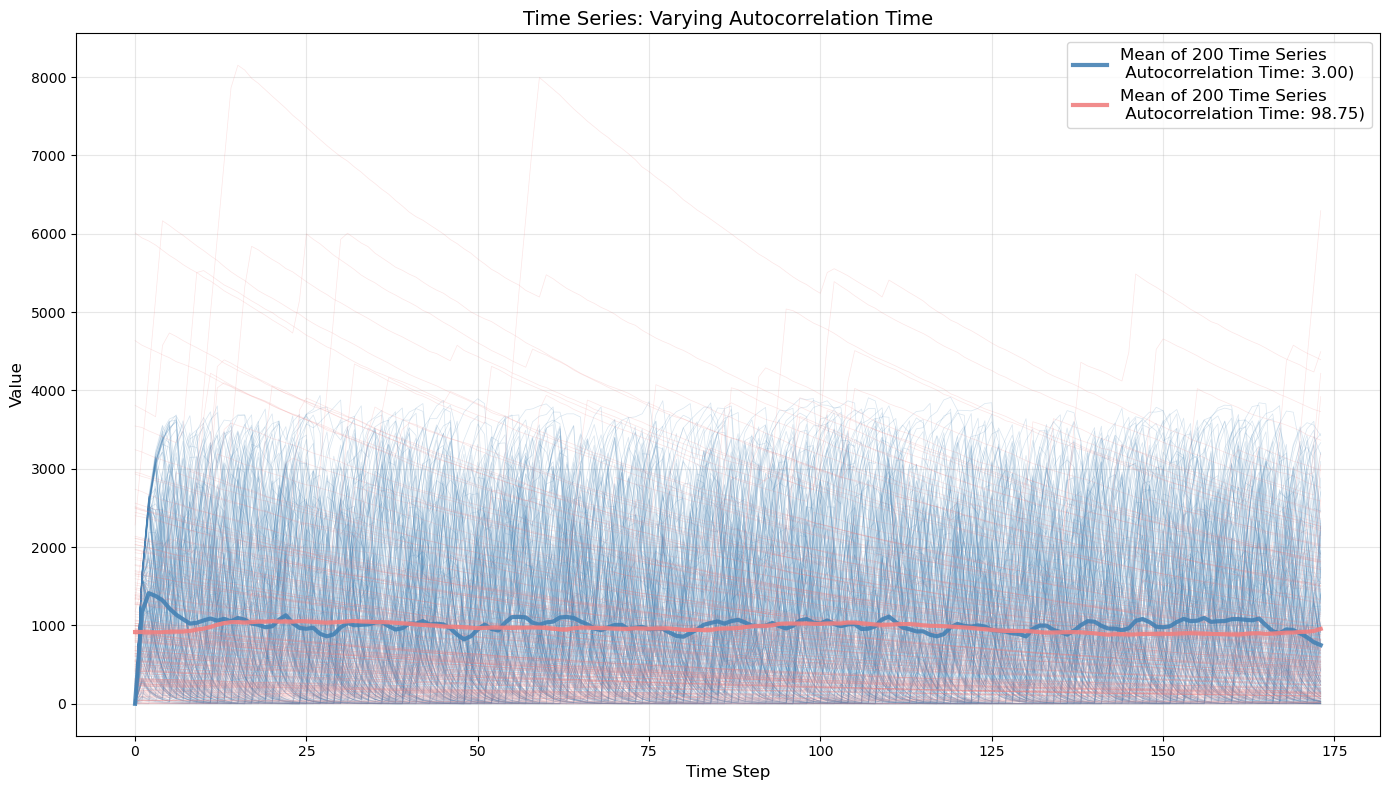

📊 Class Statistics:
Class 0: 200 time series
Class 1: 200 time series
Class 0 mean range: [0.000, 1412.290]
Class 1 mean range: [882.575, 1058.425]
Mean difference between classes: 84.473


In [77]:
# # =========================================================
# Plot Mean Time Series by Class with Individual Series in Background
# =========================================================

# Separate time series by class
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

X_class_0 = X[class_0_indices]
X_class_1 = X[class_1_indices]

# Calculate means
mean_class_0 = np.mean(X_class_0, axis=0)
mean_class_1 = np.mean(X_class_1, axis=0)

# get the corresponding t_ac values
t_ac_class_0 = lowest_t_ac_df['t_ac_target']
t_ac_class_1 = highest_t_ac_df['t_ac_target']

time_steps = np.arange(X.shape[1])

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot individual time series in background (transparent)
for i in range(len(X_class_0)):
    ax.plot(time_steps, X_class_0[i], color='steelblue', alpha=0.2, linewidth=0.5)

for i in range(len(X_class_1)):
    ax.plot(time_steps, X_class_1[i], color='lightcoral', alpha=0.2, linewidth=0.5)

# Plot mean time series (bold)
ax.plot(time_steps, mean_class_0, color='steelblue', linewidth=3, 
        label=f'Mean of {len(X_class_0)} Time Series\n Autocorrelation Time: {t_ac_class_0:.2f})', alpha=0.9)
ax.plot(time_steps, mean_class_1, color='lightcoral', linewidth=3, 
        label=f'Mean of {len(X_class_1)} Time Series\n Autocorrelation Time: {t_ac_class_1:.2f})', alpha=0.9)

# Customize plot
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Time Series: Varying Autocorrelation Time', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"📊 Class Statistics:")
print(f"Class 0: {len(X_class_0)} time series")
print(f"Class 1: {len(X_class_1)} time series")
print(f"Class 0 mean range: [{np.min(mean_class_0):.3f}, {np.max(mean_class_0):.3f}]")
print(f"Class 1 mean range: [{np.min(mean_class_1):.3f}, {np.max(mean_class_1):.3f}]")
print(f"Mean difference between classes: {np.mean(np.abs(mean_class_0 - mean_class_1)):.3f}")

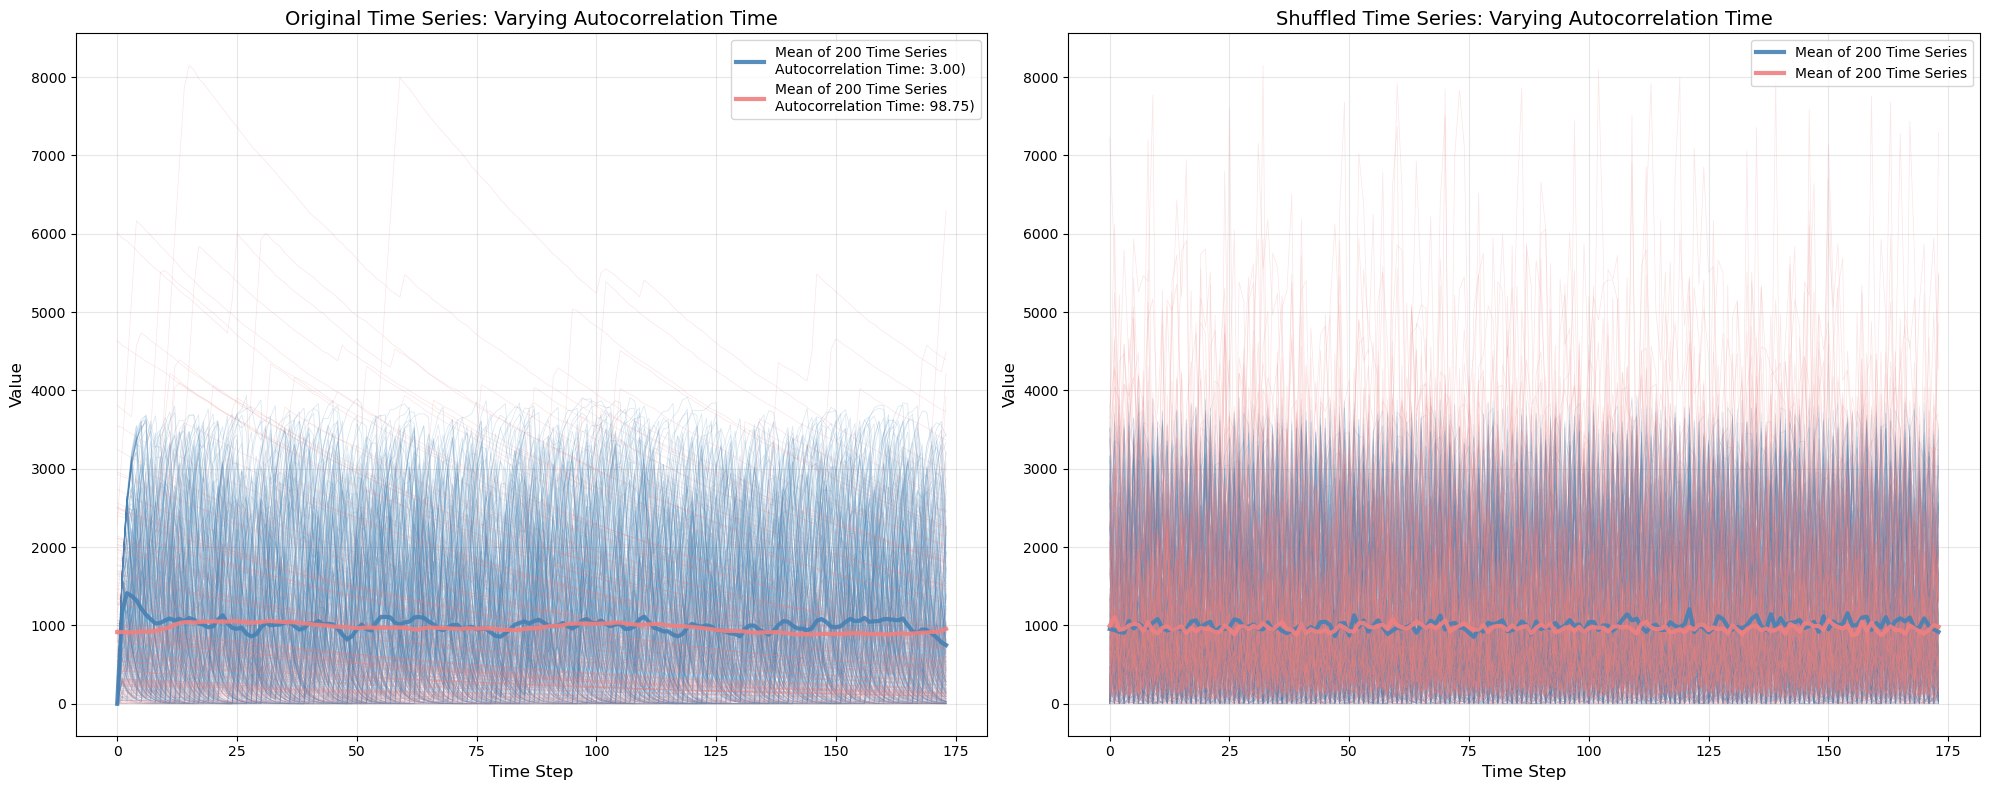

📊 Class Statistics:
Class 0: 200 time series
Class 1: 200 time series
Original - Class 0 mean range: [0.000, 1412.290]
Original - Class 1 mean range: [882.575, 1058.425]
Shuffled - Class 0 mean range: [853.365, 1206.980]
Shuffled - Class 1 mean range: [874.110, 1104.965]
Original mean difference between classes: 84.473
Shuffled mean difference between classes: 67.048


In [76]:
# =========================================================
# Plot Mean Time Series by Class with Individual Series in Background
# =========================================================

# Separate time series by class
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

X_class_0 = X[class_0_indices]
X_class_1 = X[class_1_indices]

# Separate shuffled time series by class
X_shuffled_class_0 = X_shuffled[class_0_indices]
X_shuffled_class_1 = X_shuffled[class_1_indices]

# Calculate means
mean_class_0 = np.mean(X_class_0, axis=0)
mean_class_1 = np.mean(X_class_1, axis=0)
mean_shuffled_class_0 = np.mean(X_shuffled_class_0, axis=0)
mean_shuffled_class_1 = np.mean(X_shuffled_class_1, axis=0)

# get the corresponding t_ac values
t_ac_class_0 = lowest_t_ac_df['t_ac_target']
t_ac_class_1 = highest_t_ac_df['t_ac_target']

time_steps = np.arange(X.shape[1])

# Create the plot with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Original time series plot
# Plot individual time series in background (transparent)
for i in range(len(X_class_0)):
    ax1.plot(time_steps, X_class_0[i], color='steelblue', alpha=0.2, linewidth=0.5)

for i in range(len(X_class_1)):
    ax1.plot(time_steps, X_class_1[i], color='lightcoral', alpha=0.2, linewidth=0.5)

# Plot mean time series (bold)
ax1.plot(time_steps, mean_class_0, color='steelblue', linewidth=3, 
        label=f'Mean of {len(X_class_0)} Time Series\nAutocorrelation Time: {t_ac_class_0:.2f})', alpha=0.9)
ax1.plot(time_steps, mean_class_1, color='lightcoral', linewidth=3, 
        label=f'Mean of {len(X_class_1)} Time Series\nAutocorrelation Time: {t_ac_class_1:.2f})', alpha=0.9)

# Customize original plot
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title('Original Time Series: Varying Autocorrelation Time', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Shuffled time series plot
# Plot individual shuffled time series in background (transparent)
for i in range(len(X_shuffled_class_0)):
    ax2.plot(time_steps, X_shuffled_class_0[i], color='steelblue', alpha=0.2, linewidth=0.5)

for i in range(len(X_shuffled_class_1)):
    ax2.plot(time_steps, X_shuffled_class_1[i], color='lightcoral', alpha=0.2, linewidth=0.5)

# Plot mean shuffled time series (bold)
ax2.plot(time_steps, mean_shuffled_class_0, color='steelblue', linewidth=3, 
        label=f'Mean of {len(X_shuffled_class_0)} Time Series', alpha=0.9)
ax2.plot(time_steps, mean_shuffled_class_1, color='lightcoral', linewidth=3, 
        label=f'Mean of {len(X_shuffled_class_1)} Time Series', alpha=0.9)

# Customize shuffled plot
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.set_title('Shuffled Time Series: Varying Autocorrelation Time', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"📊 Class Statistics:")
print(f"Class 0: {len(X_class_0)} time series")
print(f"Class 1: {len(X_class_1)} time series")
print(f"Original - Class 0 mean range: [{np.min(mean_class_0):.3f}, {np.max(mean_class_0):.3f}]")
print(f"Original - Class 1 mean range: [{np.min(mean_class_1):.3f}, {np.max(mean_class_1):.3f}]")
print(f"Shuffled - Class 0 mean range: [{np.min(mean_shuffled_class_0):.3f}, {np.max(mean_shuffled_class_0):.3f}]")
print(f"Shuffled - Class 1 mean range: [{np.min(mean_shuffled_class_1):.3f}, {np.max(mean_shuffled_class_1):.3f}]")
print(f"Original mean difference between classes: {np.mean(np.abs(mean_class_0 - mean_class_1)):.3f}")
print(f"Shuffled mean difference between classes: {np.mean(np.abs(mean_shuffled_class_0 - mean_shuffled_class_1)):.3f}")